# Setup

In [1]:
DATA_VERSION = "2025-10-06"
DATA_FILE_NAME = f"consultation-documents-preprocessed-{DATA_VERSION}.parquet"
EXTRA_DOCUMENT_FEATURES_FILE_NAME = f"consultation-documents-features-{DATA_VERSION}.parquet"
EMBEDDINGS_FILE_NAME = (
    f"consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-{DATA_VERSION}.parquet"
)

LANGUAGES = {
    "de",
    # "fr",
    # "it",
}

FROM_YEAR = 2000

# Do not train nor test on documents from cantons that have known data quality issues.
EXCLUDE_POLITICAL_BODIES = {
    "bl",
    "ge",
    "ne",
    "sz",
    "vd",
    "vs",
}

INCLUDE_RULE_LABELS_IN_TRAINING = {
    # These are labels after class merging.
    "SYNOPTIC_TABLE",
    "LETTER",
    "RECIPIENT_LIST",
    "FINAL_REPORT",
    "SURVEY",
}

CV_FOLDS = 5
# This fraction only applies to manually labelled OpenParlData documents. Many more documents make it
# into the training set, e.g. all Fedlex documents.
TEST_SIZE = 0.15
RANDOM_STATE = 271828

# RUN_HYPEROPTIMIZATION = True
# HYPERPARAMETERS = None

RUN_HYPEROPTIMIZATION = False
# HYPERPARAMETERS = {
#     "classifier": {
#         "type": "MLP",
#         "activation": "relu",
#         "alpha": 7.347549520407708e-05,
#         "batch_size": 144,
#         "layer_1": 240,
#         "layer_2": 48,
#         "layer_3": 208,
#         "learning_rate_init": 0.00013505066692205835,
#         "n_layers": 1,
#         "solver": "adam",
#     },
#     "pca_n_components": 360,
# }
HYPERPARAMETERS = {
    "classifier": {
        "type": "SVC",
        "C": 1.0,
        "class_weight": None,
        "gamma": "scale",
        "kernel": {"type": "rbf"},
    },
    "pca_n_components": 100,
}

assert RUN_HYPEROPTIMIZATION ^ bool(HYPERPARAMETERS)

In [2]:
%load_ext autoreload
%autoreload 2

import logging
import pathlib
import sys
from typing import Any

import dotenv
import duckdb
import hyperopt
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline
from hyperopt import pyll

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
import demokratis_ml.data.loading
import demokratis_ml.models.document_types.model
import demokratis_ml.models.document_types.preprocessing
from research.document_types import document_title_rule_model, training_split
from research.lib import data_access, plotting, utils

In [4]:
dotenv.load_dotenv()
utils.set_up_logging_and_mlflow("VM_document_type_classifier")

mlflow.log_param("data_version", DATA_VERSION)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("extra_features_file", EXTRA_DOCUMENT_FEATURES_FILE_NAME)
mlflow.log_param("embeddings_file", EMBEDDINGS_FILE_NAME)
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
mlflow.log_param("run_hyperoptimization", RUN_HYPEROPTIMIZATION)
mlflow.log_param("include_rule_labels_in_training", sorted(INCLUDE_RULE_LABELS_IN_TRAINING))
mlflow.log_param("exclude_political_bodies", sorted(EXCLUDE_POLITICAL_BODIES))
mlflow.log_param("merge_classes", demokratis_ml.models.document_types.preprocessing.MERGE_CLASSES)
;

INFO research.lib.utils: MLflow tracking to https://mlflow.ml1.demokratis.ch/
INFO research.lib.utils: Starting run = dapper-frog-74


''

# Input data preparation

## Get all dataframes

In [5]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

FEATURES_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EXTRA_DOCUMENT_FEATURES_FILE_NAME
data_access.ensure_dataframe_is_available(FEATURES_DATA_FILE)

EMBEDDINGS_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EMBEDDINGS_FILE_NAME
data_access.ensure_dataframe_is_available(EMBEDDINGS_DATA_FILE)

INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-10-06.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-features-2025-10-06.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-2025-10-06.parquet already exists locally.


In [6]:
db_conn = duckdb.connect(":memory:")

rel_docs = demokratis_ml.data.loading.filter_documents(
    db_conn.from_parquet(str(PREPROCESSED_DATA_FILE)),
    only_languages=LANGUAGES,
    only_consultations_since_year=FROM_YEAR,
)
rel_features = db_conn.from_parquet(str(FEATURES_DATA_FILE))
rel_embeddings = db_conn.from_parquet(str(EMBEDDINGS_DATA_FILE))

## Preprocess

In [7]:
df_input = demokratis_ml.models.document_types.preprocessing.create_input_dataframe(
    rel_docs, rel_extra_features=rel_features, rel_embeddings=rel_embeddings
)
df_input

INFO document_types.preprocessing: Dropping 0 documents (0.0%) with empty texts


,document_id,document_uuid,consultation_identifier,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,...,average_page_aspect_ratio,embedding,fraction_pages_containing_tables,fraction_pages_containing_images,contains_synopse_keyword,contains_salutation,days_after_consultation_start,days_after_consultation_end,consultation_start_timestamp,is_federal_consultation
0,1,1CAJoURQMxKeqCdQ4jLniS,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",...,0.704898,"[0.01030252780765295, -0.014312159270048141, -...",0.000000,0.000000,False,False,4.0,-104.0,1633046400,True
1,4,1CAJoURQMxKeqCdQ4vhCQx,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",...,0.707098,"[0.011395552195608616, 0.0014780974015593529, ...",0.000000,0.166667,False,False,4.0,-104.0,1633046400,True
2,7,1CAJoURQMxKeqCdQ564eYH,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",...,0.707098,"[-0.005767590366303921, 0.002646328415721655, ...",0.000000,0.500000,False,True,4.0,-104.0,1633046400,True
3,10,1CAJoURQbi5gxw7Wp5N5rT,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",...,0.707098,"[0.019797369837760925, -0.00907826703041792, -...",0.000000,0.400000,False,False,4.0,-104.0,1633046400,True
4,13,1CAJoURQbi5gxw7WpL8ns1,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",...,0.707098,"[-0.001758241094648838, 0.002000046195462346, ...",0.000000,0.500000,False,True,4.0,-104.0,1633046400,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21355,56746,1CTD5PcZXB4zkGfMn87Gm5,j48s6m74,2024-10-30,2025-02-18,Änderung der Verordnung über die Unfallversich...,Artikel 95a UVV muss aus formellen Gründen dem...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/j48s6m74,"[economics, health, insurance]",...,0.707186,"[0.012035108171403408, -0.019328873604536057, ...",0.135135,1.000000,False,True,321.0,210.0,1730246400,True
21356,56752,1CTD5Pd8zJUMt6o4MX6WhR,8vzwky3r,2024-11-21,2025-03-14,Parlamentarische Initiative. Armut ist kein Ve...,"Die Kommission schlägt vor, das Ausländer- und...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/8vzwky3r,"[administration, migration, social]",...,NaN,"[0.020221352577209473, -0.01260434091091156, -...",NaN,NaN,False,True,299.0,186.0,1732147200,True
21357,56828,1CTJkr3pq6H2tGguGvLrFC,k8qvv6ee,2025-04-30,2025-08-20,Änderung der Mindestbesteuerungsverordnung (Er...,Die Berichtspflicht im Rahmen der OECD-Pillar-...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/k8qvv6ee,"[foreign_policy, it, public_finance]",...,NaN,"[0.017069872468709946, -0.0017331440467387438,...",NaN,NaN,False,True,142.0,30.0,1745971200,True
21358,57122,1CTjNKv5x6dey8BgCinuBW,bu94twhn,2025-05-28,2025-09-18,Änderung des Obligationenrechts (Verlängerung ...,Artike

In [8]:
embedding_dimension = df_input["embedding"].iloc[0].shape[0]
print("Embedding dimension:", embedding_dimension)

Embedding dimension: 3072


In [9]:
print(
    "Excluding documents from these political bodies from the data:",
    df_input[df_input["political_body"].isin(EXCLUDE_POLITICAL_BODIES)]["political_body"].astype(str).value_counts(),
    sep="\n",
)
df_input = df_input[~df_input["political_body"].isin(EXCLUDE_POLITICAL_BODIES)]

Excluding documents from these political bodies from the data:
political_body
sz    440
vs     12
bl      9
Name: count, dtype: int64


## Split

In [10]:
df_input_train, (df_input_test_1, df_input_test_2) = training_split.train_test_split(
    df_input,
    random_state=RANDOM_STATE,
    test_sizes=(TEST_SIZE, TEST_SIZE),
    include_rule_labels_in_training=INCLUDE_RULE_LABELS_IN_TRAINING,
    stratify_by_canton=False,
)

INFO document_title_rule_model: 0.00% of documents already have labels
INFO document_title_rule_model: Labelled 0.37% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 3.37% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.27% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.96% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.02% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
INFO document_title_ru

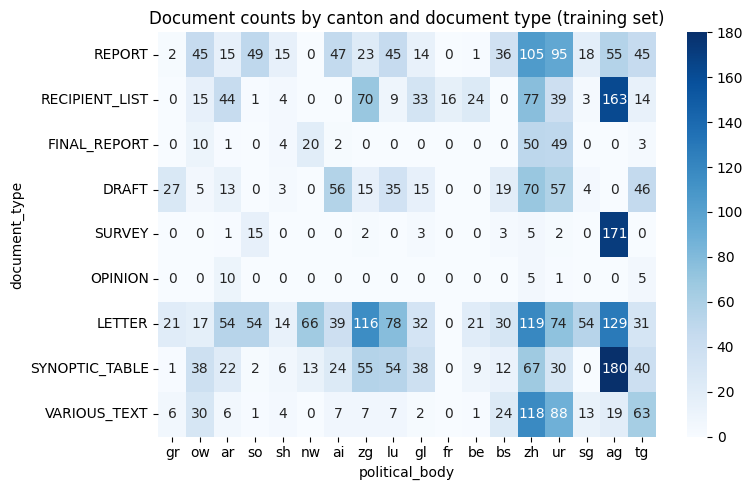

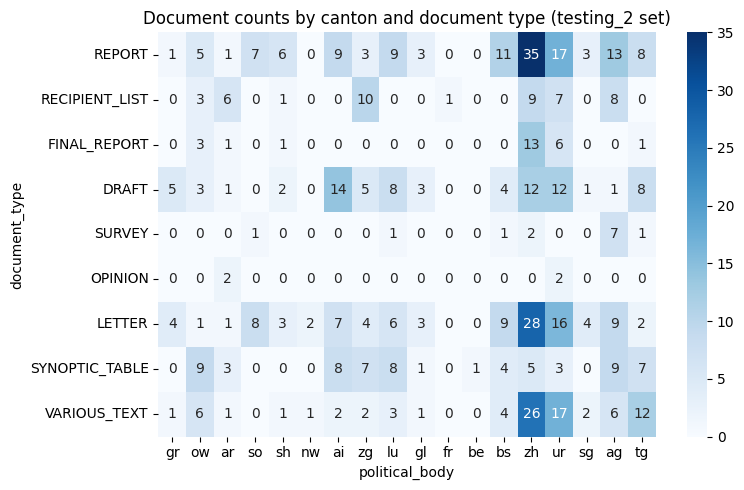

In [11]:
def plot_documents_per_canton(df: pd.DataFrame, set_name: str) -> None:
    df = df[df["political_body"] != "ch"]
    count_matrix = pd.crosstab(df["document_type"], df["political_body"])
    count_matrix = count_matrix.fillna(0)
    plt.figure(figsize=(8, 5))
    sns.heatmap(count_matrix, annot=True, fmt="g", cmap="Blues")
    plt.title(f"Document counts by canton and document type ({set_name} set)")
    plt.tight_layout()
    plt.show()


plot_documents_per_canton(df_input_train, "training")
plot_documents_per_canton(df_input_test_2, "testing_2")

In [12]:
display(df_input_train["document_type_label_source"].value_counts(dropna=False))
display(df_input_train["document_type"].value_counts(dropna=False))

document_type_label_source
fedlex    13063
manual     2580
rule       1205
Name: count, dtype: int64

document_type
LETTER            3547
DRAFT             3363
REPORT            2842
RECIPIENT_LIST    2343
FINAL_REPORT      1952
OPINION           1027
VARIOUS_TEXT       815
SYNOPTIC_TABLE     728
SURVEY             231
DECISION             0
PRESS_RELEASE        0
RESPONSE_FORM        0
LINK                 0
Name: count, dtype: int64

In [13]:
display(df_input_test_2["document_type_label_source"].value_counts(dropna=False))
display(df_input_test_2["document_type"].value_counts(dropna=False))

document_type_label_source
manual    554
fedlex      0
rule        0
Name: count, dtype: int64

document_type
REPORT            131
LETTER            107
VARIOUS_TEXT       85
DRAFT              79
SYNOPTIC_TABLE     65
RECIPIENT_LIST     45
FINAL_REPORT       25
SURVEY             13
OPINION             4
DECISION            0
PRESS_RELEASE       0
RESPONSE_FORM       0
LINK                0
Name: count, dtype: int64

In [14]:
mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_1_samples_count", len(df_input_test_1))
mlflow.log_param("test_2_samples_count", len(df_input_test_2))

554

# Data exploration

## Data representation

In [15]:
print("df_input_train labels:")
df_input_train.groupby("document_type_label_source", observed=False)["document_type"].value_counts(dropna=False)

df_input_train labels:


document_type_label_source  document_type 
fedlex                      DRAFT             2998
                            LETTER            2598
                            REPORT            2232
                            RECIPIENT_LIST    1831
                            FINAL_REPORT      1813
                            OPINION           1006
                            VARIOUS_TEXT       419
                            SYNOPTIC_TABLE     137
                            SURVEY              29
                            DECISION             0
                            PRESS_RELEASE        0
                            RESPONSE_FORM        0
                            LINK                 0
rule                        LETTER             449
                            RECIPIENT_LIST     301
                            SYNOPTIC_TABLE     291
                            SURVEY             143
                            FINAL_REPORT        21
                            REPORT     

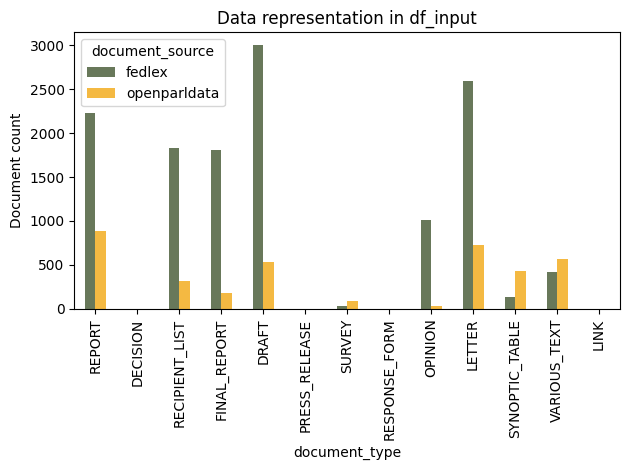

document_source,fedlex,openparldata
document_type,,
REPORT,2232,884
DECISION,0,0
RECIPIENT_LIST,1831,313
FINAL_REPORT,1813,184
DRAFT,2998,535
PRESS_RELEASE,0,0
SURVEY,29,87
RESPONSE_FORM,0,0
OPINION,1006,31


In [16]:
repr_table = df_input.pivot_table(
    index="document_type", columns="document_source", aggfunc="size", fill_value=0, observed=False
)
display(
    plotting.plot_and_log(
        repr_table.plot,
        "data_representation.png",
        title="Data representation in df_input",
        kind="bar",
        ylabel="Document count",
        color=["#68785A", "#F4B942"],
    )
)
display(repr_table)

## Extra features

In [17]:
print("contains_salutation:")
df_input.pivot_table(
    index="document_type",
    columns="document_source",
    values="contains_salutation",
    aggfunc="mean",
    fill_value=0,
    observed=False,
)

contains_salutation:


document_source,fedlex,openparldata
document_type,,
REPORT,0.012545,0.047511
RECIPIENT_LIST,0.000000,0.000000
FINAL_REPORT,0.002758,0.059783
DRAFT,0.001001,0.000000
SURVEY,0.000000,0.034483
OPINION,0.737575,0.612903
LETTER,0.984988,0.993151
SYNOPTIC_TABLE,0.000000,0.002294
VARIOUS_TEXT,0.014320,0.042403


### Keyword-like features

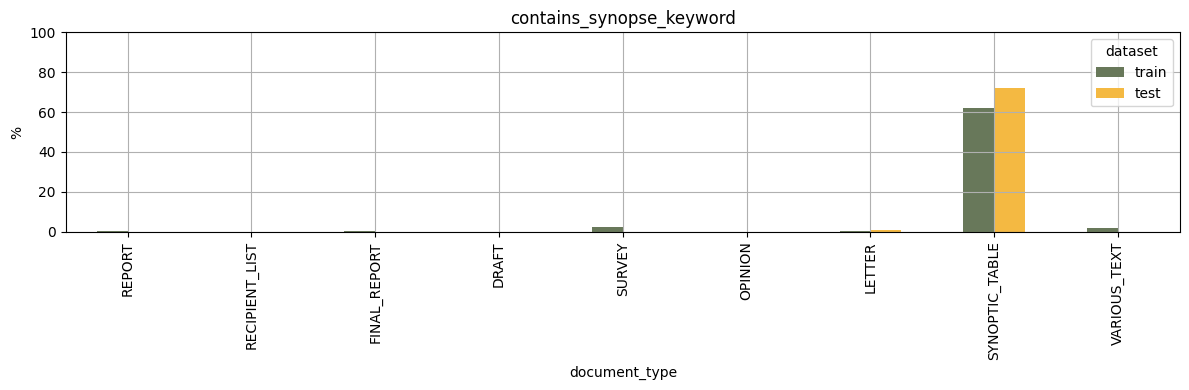

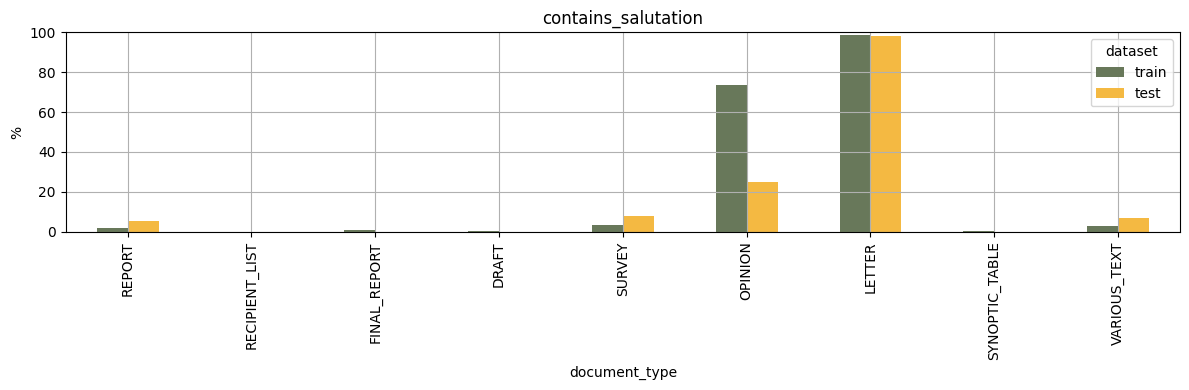

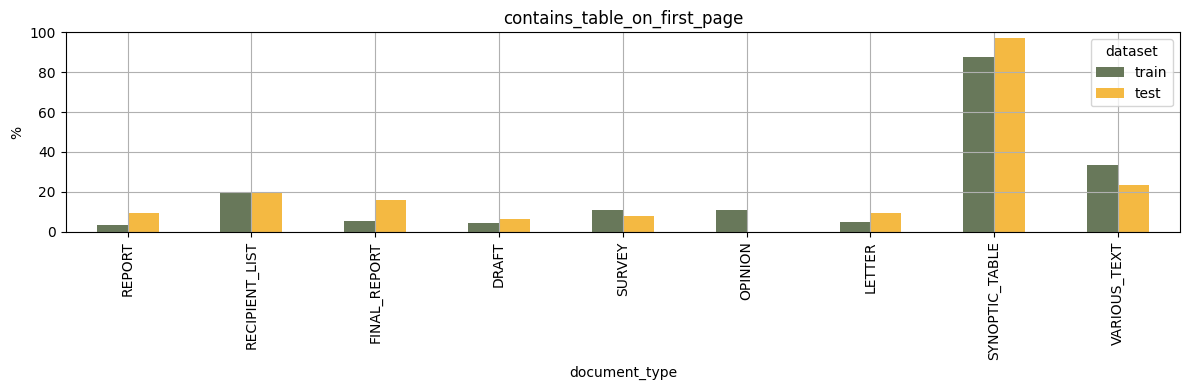

In [18]:
def plot_binary_feature_across_document_types(df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str) -> None:
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    pivot_table = df.pivot_table(
        index="document_type",
        columns="dataset",
        values=feature_name,
        aggfunc=lambda x: 100 * x.mean(),
        fill_value=0,
        observed=False,
    )
    pivot_table = pivot_table[["train", "test"]]  # Ensure "train" comes first
    ax = pivot_table.plot(
        kind="bar",
        # figsize=(20, 10),
        figsize=(12, 4),
        title=feature_name,
        ylabel="%",
        ylim=(0, 100),
        color=["#68785A", "#F4B942"],
        grid=True,
    )
    ax.figure.patch.set_alpha(0.0)
    ax.patch.set_alpha(0.0)
    plt.tight_layout()
    plt.show()


plot_binary_feature_across_document_types(df_input_train, df_input_test_2, "contains_synopse_keyword")
plot_binary_feature_across_document_types(df_input_train, df_input_test_2, "contains_salutation")
plot_binary_feature_across_document_types(df_input_train, df_input_test_2, "contains_table_on_first_page")

In [19]:
def plot_feature_distribution_across_document_types(
    df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str, clip_y: None | tuple[int, int] = None
) -> None:
    plt.figure(figsize=(14, 5))
    # plt.figure(figsize=(20, 10))
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
        ignore_index=True,
    )
    ax = sns.violinplot(
        data=df,
        x="document_type",
        y=feature_name,
        hue="dataset",
        order=sorted(df["document_type"].unique()),
        # inner="box",  # Show boxplot inside violin
        inner=None,  # Show only violin
        split=True,
        linewidth=0.1,
        palette={"train": "#68785A", "test": "#F4B942"},
    )
    # ax.set_ylim(bottom=0, top=1)
    ax.figure.patch.set_alpha(0.0)
    ax.patch.set_alpha(0.0)
    plt.xticks(rotation=90)
    if clip_y:
        sample = df[feature_name].dropna()
        ax.set_ylim(*np.percentile(sample, clip_y))
        plt.title(f"{feature_name} (clipped to {clip_y[0]}-{clip_y[1]}th percentile)")
    else:
        plt.title(feature_name)
    plt.tight_layout()
    plt.show()

### Page count, aspect ratio

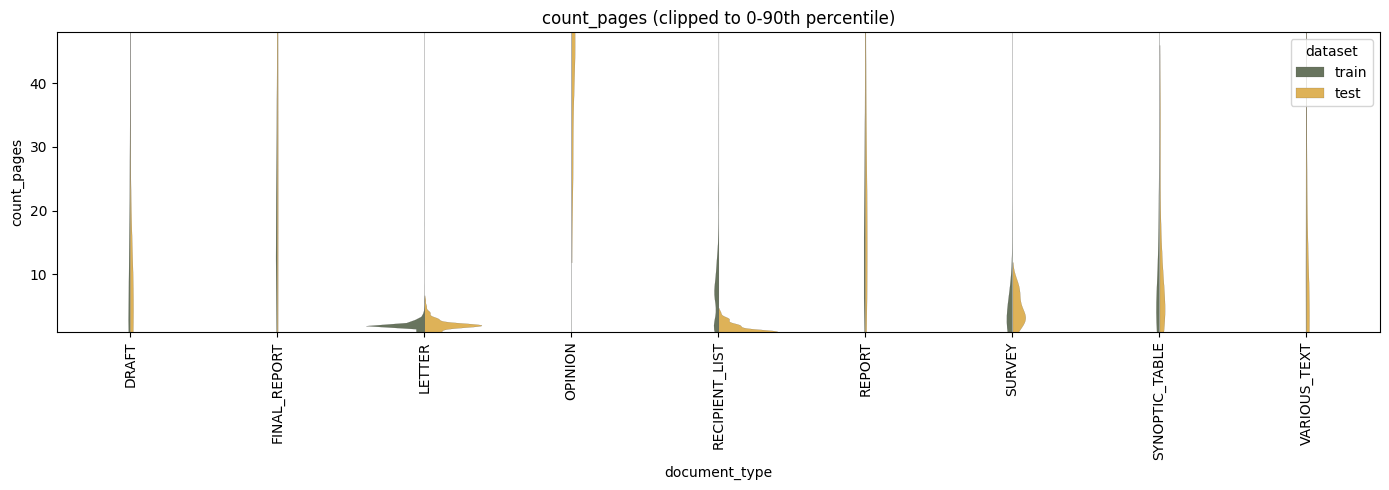

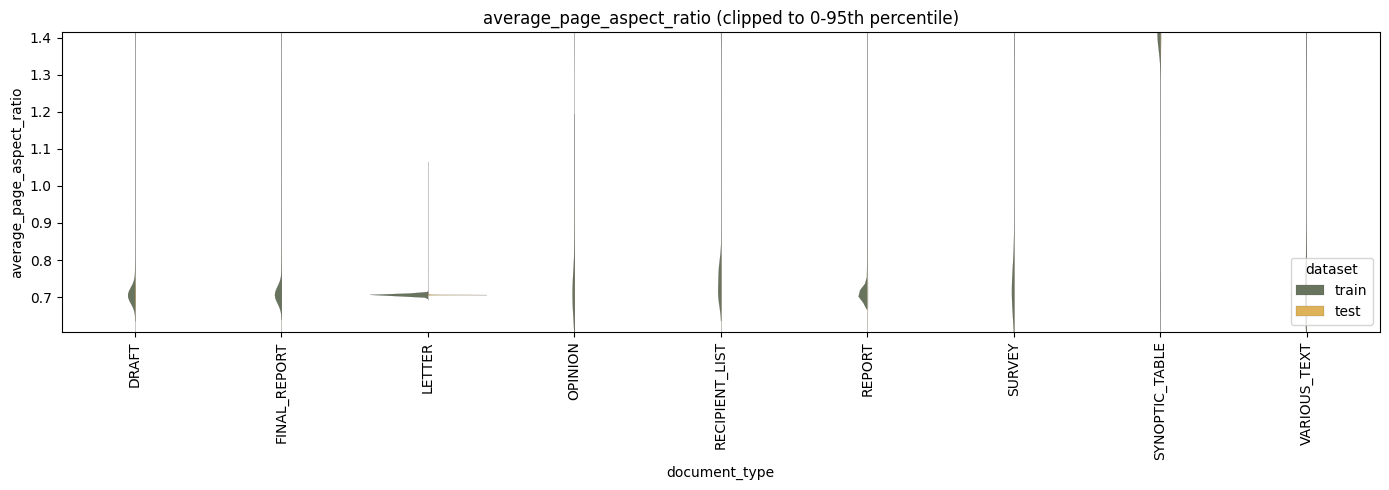

In [20]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "count_pages", clip_y=(0, 90))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test_2, "average_page_aspect_ratio", clip_y=(0, 95)
)

In [21]:
print("count_pages")
pd.concat([df_input_train.assign(dataset="train"), df_input_test_2.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="count_pages",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

count_pages


mean                    std            
dataset              test       train       test       train
document_type                                               
REPORT          26.488550   25.416960  28.512714   34.643002
RECIPIENT_LIST   1.511111    7.209134   0.786887    5.592080
FINAL_REPORT    42.120000   26.609631  54.659034   42.333961
DRAFT            9.822785   13.538507  21.631980   43.967329
SURVEY           4.615385    4.857143   2.433737    7.764548
OPINION         41.750000  386.576436   9.979145  794.685607
LETTER           2.177570    2.150268   0.909210    1.346059
SYNOPTIC_TABLE   9.353846   10.984890   9.250728   15.651765
VARIOUS_TEXT    10.670588   19.685890  20.618639  138.864594

In [22]:
print("average_page_aspect_ratio")
pd.concat([df_input_train.assign(dataset="train"), df_input_test_2.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="average_page_aspect_ratio",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

average_page_aspect_ratio


mean                 std          
dataset             test     train      test     train
document_type                                         
REPORT          0.774954  0.722719  0.171091  0.082216
RECIPIENT_LIST  0.785645  0.770883  0.224837  0.152535
FINAL_REPORT    0.876250  0.726559  0.286993  0.102242
DRAFT           0.715428  0.727540  0.081203  0.107784
SURVEY          0.766527  0.770989  0.195455  0.181463
OPINION         0.776657  0.787141  0.139075  0.201062
LETTER          0.707187  0.707777  0.000686  0.013865
SYNOPTIC_TABLE  1.387137  1.364913  0.129763  0.173331
VARIOUS_TEXT    0.813143  0.888127  0.259640  0.314577

### Tables

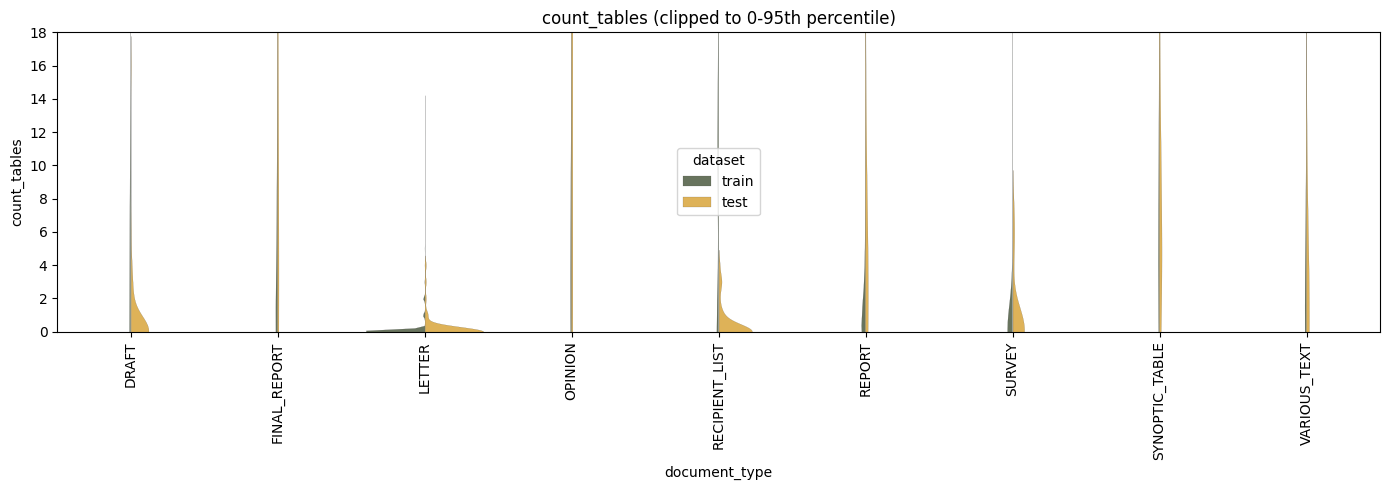

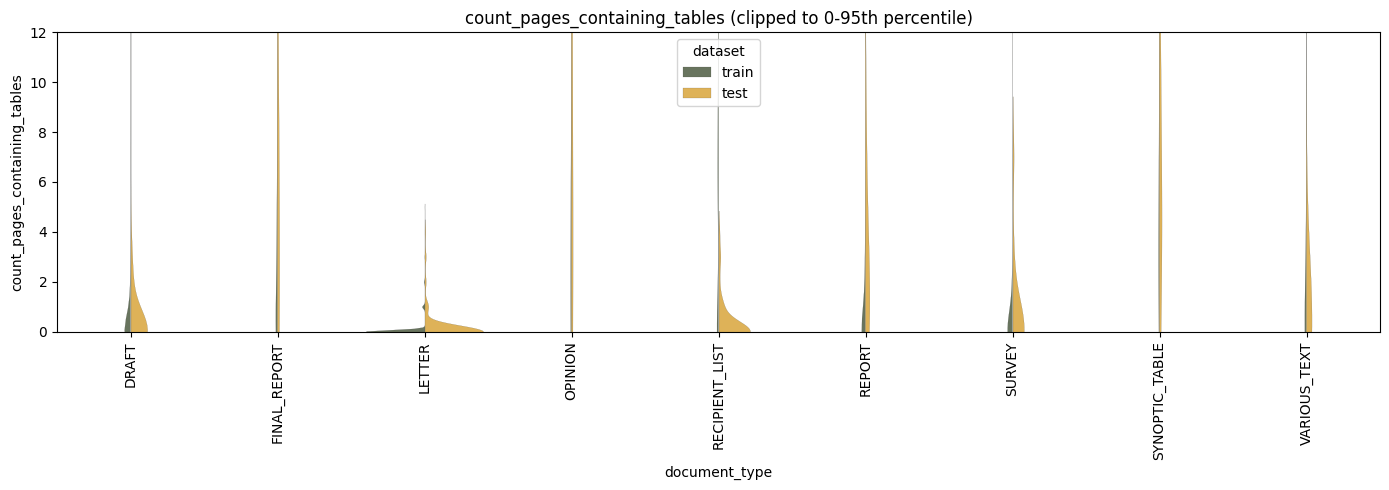

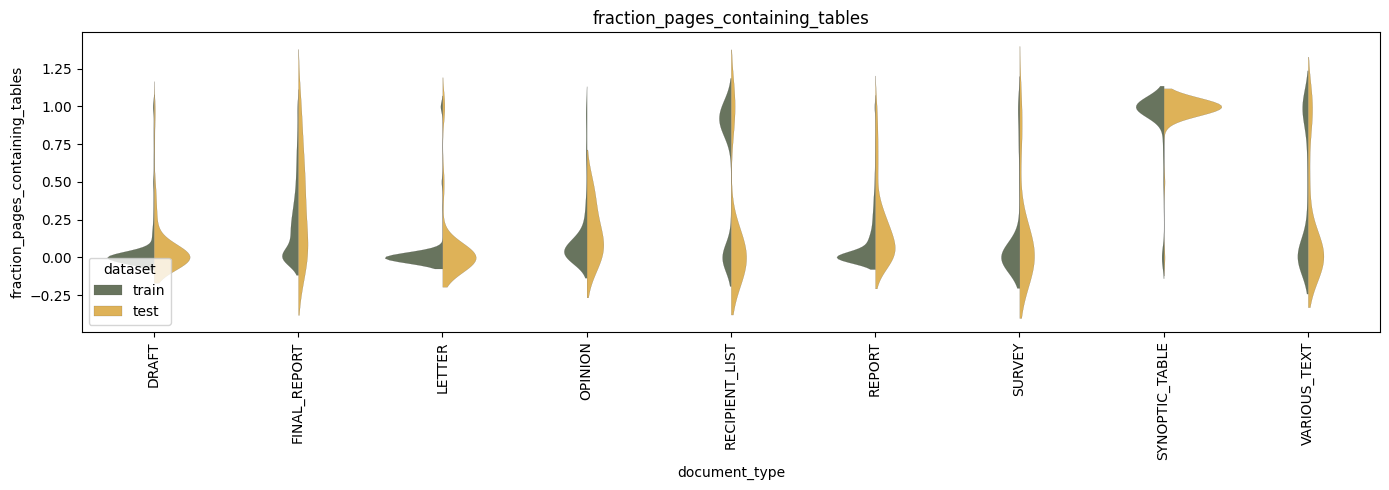

In [23]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "count_tables", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test_2, "count_pages_containing_tables", clip_y=(0, 95)
)
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "fraction_pages_containing_tables")

### Images

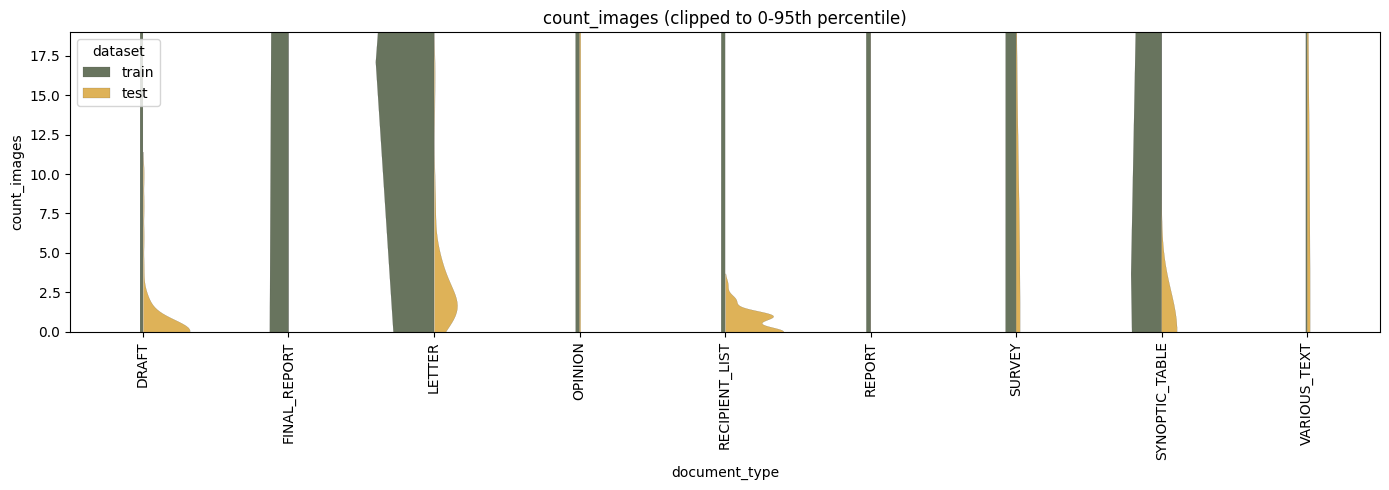

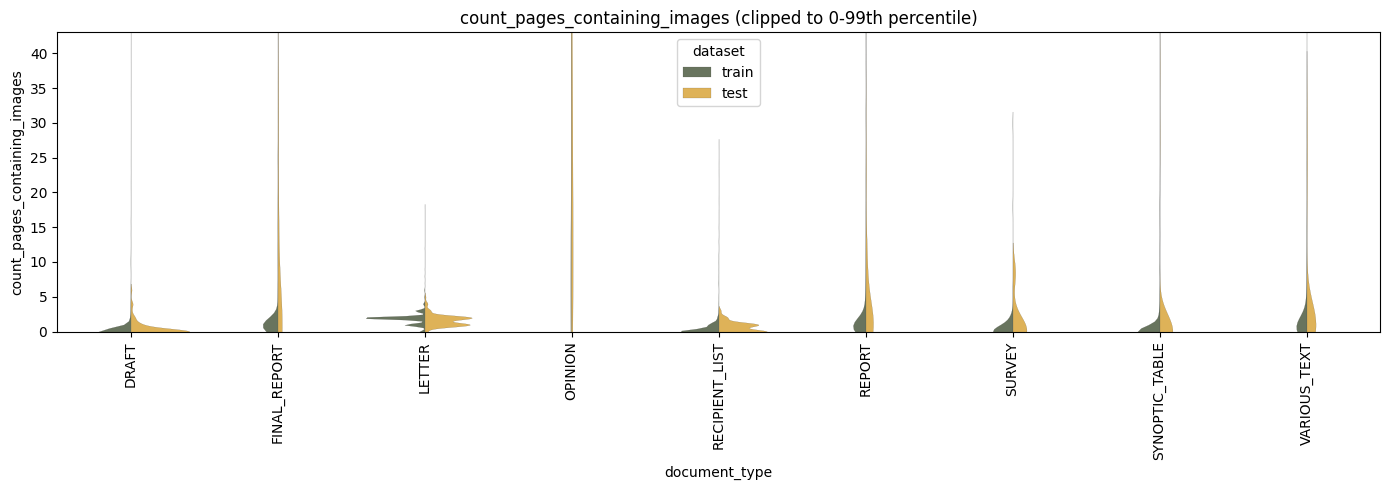

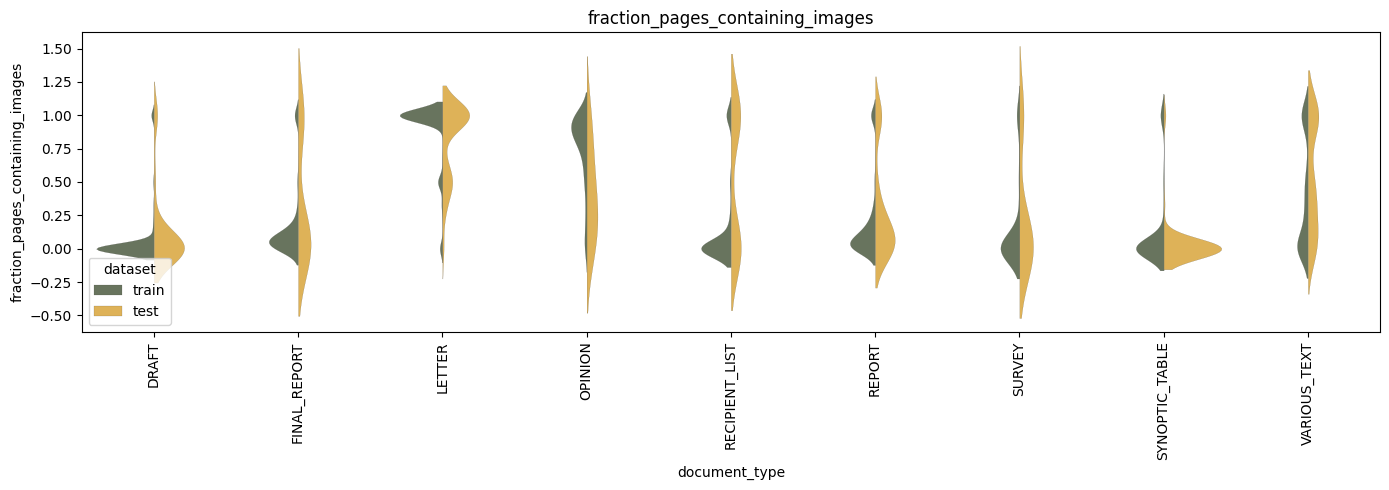

In [24]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "count_images", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test_2, "count_pages_containing_images", clip_y=(0, 99)
)
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "fraction_pages_containing_images")

### Time features

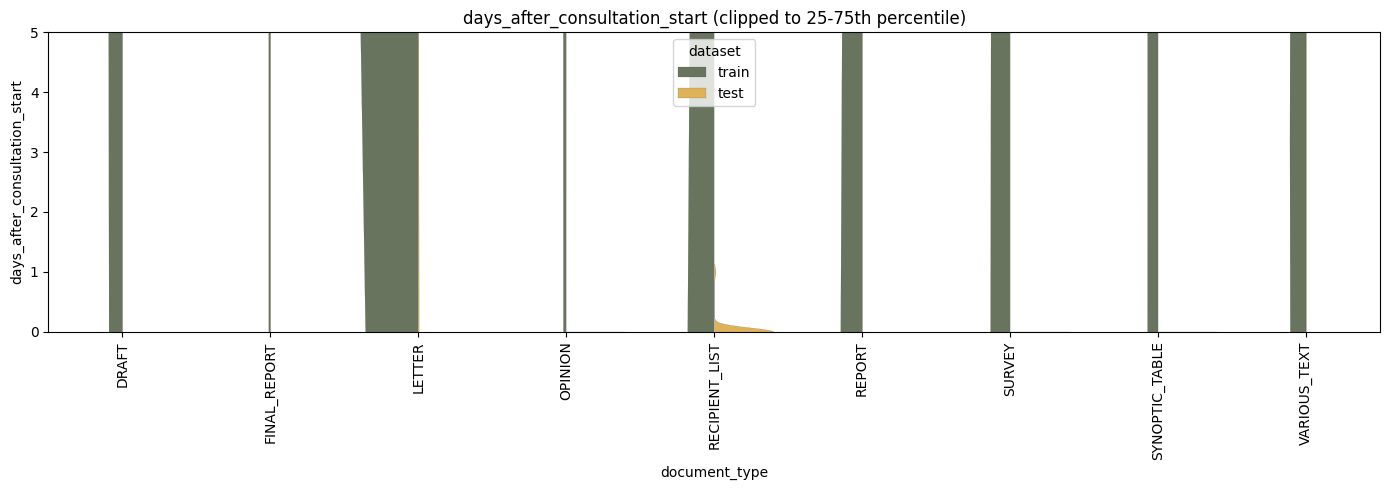

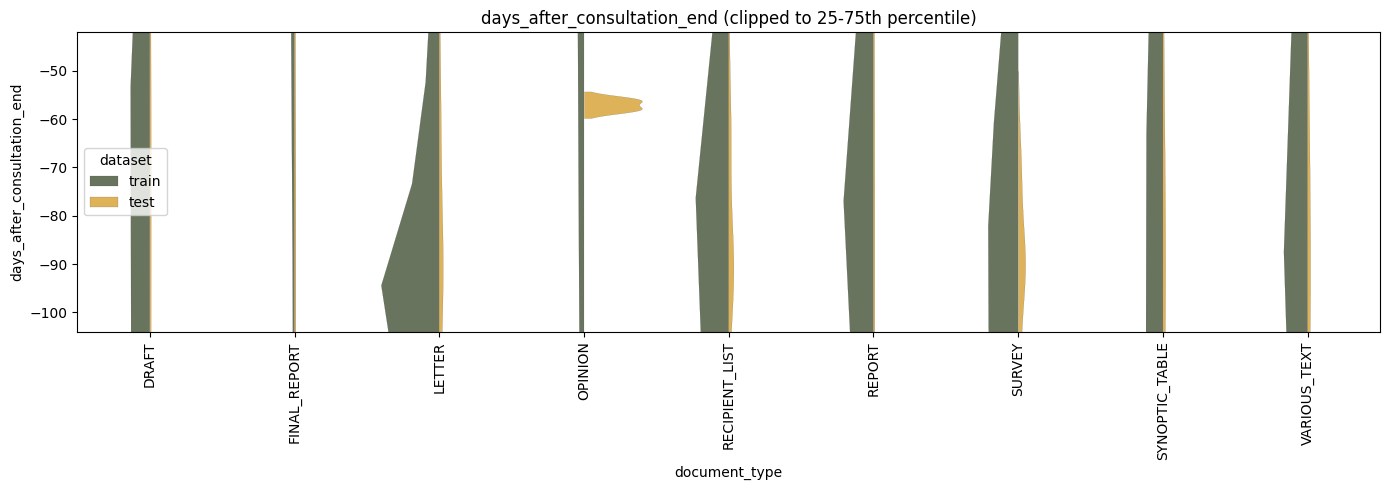

In [25]:
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test_2,
    "days_after_consultation_start",
    clip_y=(25, 75),
)
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test_2,
    "days_after_consultation_end",
    clip_y=(25, 75),
)

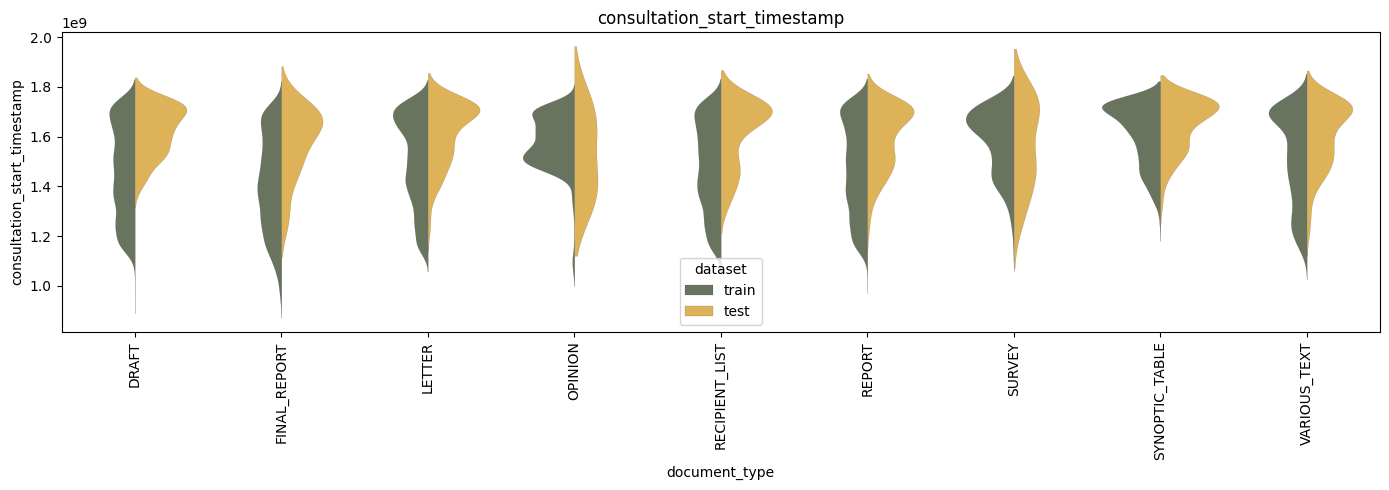

In [26]:
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test_2,
    "consultation_start_timestamp",
    # clip_y=(25, 75),
)

# Classification

In [27]:
mlflow.log_param("extra_feature_columns", sorted(demokratis_ml.models.document_types.model.EXTRA_FEATURE_COLUMNS))
mlflow.log_param(
    "extra_categorical_feature_columns", sorted(demokratis_ml.models.document_types.model.EXTRA_CATEGORICAL_COLUMNS)
)

X_train, y_train = demokratis_ml.models.document_types.model.create_matrices(df_input_train)
X_test_1, y_test_1 = demokratis_ml.models.document_types.model.create_matrices(df_input_test_1)
X_test_2, y_test_2 = demokratis_ml.models.document_types.model.create_matrices(df_input_test_2)

print("train", X_train.shape)
print("test_1", X_test_1.shape)
print("test_2", X_test_2.shape)

train (16848, 3084)
test_1 (553, 3084)
test_2 (554, 3084)


## Hyperoptimisation on test_1

In [28]:
def objective_function(params: dict[str, Any]) -> dict[str, Any]:
    logging.info("Training for hyperparameters: %s", params)
    # return {"loss": 1, "status": hyperopt.STATUS_OK}
    classifier = demokratis_ml.models.document_types.model.create_classifier(
        embedding_dimension=embedding_dimension,
        random_state=RANDOM_STATE,
        params=params,
    )
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test_1)
    f1 = sklearn.metrics.f1_score(y_test_1, y_pred, average="weighted", zero_division=np.nan)
    logging.info("F1=%.3f for %s", f1, params)
    return {"loss": -f1, "status": hyperopt.STATUS_OK, "params": params, "f1": f1}


max_evals = 1000

# See https://github.com/hyperopt/hyperopt/issues/253 about the scope.int call
quniform = lambda name, low, high, q: pyll.base.scope.int(hyperopt.hp.quniform(name, low, high, q))  # noqa: E731

search_space = {
    "pca_n_components": quniform("pca_n_components", 50, 400, 10),
    "classifier": hyperopt.hp.choice(
        "classifier",
        [
            # {
            #     "type": "LogisticRegression",
            # },
            # {
            #     "type": "SVC",
            #     # "C": hyperopt.hp.lognormal("svm_C", 0, 1),
            #     "C": hyperopt.hp.loguniform("svm_C", np.log(1e-3), np.log(1e3)),
            #     "gamma": hyperopt.hp.loguniform("svm_gamma", np.log(1e-4), np.log(1e1)),
            #     "kernel": hyperopt.hp.choice(
            #         "svm_kernel",
            #         [
            #             {"type": "poly", "degree": quniform("svm_poly_degree", 2, 5, 1)},
            #             {"type": "rbf"},
            #             {"type": "sigmoid"},
            #         ],
            #     ),
            #     "class_weight": hyperopt.hp.choice("svm_class_weight", ["balanced", None]),
            # },
            {
                "type": "MLP",
                # Choose number of layers (1 to 3)
                "n_layers": quniform("n_layers", 1, 3, 1),
                # Neurons per layer (up to 3 layers, fill with dummy values if not used)
                "layer_1": quniform("layer_1", 16, 256, 16),
                "layer_2": quniform("layer_2", 16, 256, 16),
                "layer_3": quniform("layer_3", 16, 256, 16),
                "activation": hyperopt.hp.choice("activation", ["relu", "tanh", "logistic"]),
                "solver": hyperopt.hp.choice("solver", ["adam", "sgd"]),
                "learning_rate_init": hyperopt.hp.loguniform("learning_rate_init", np.log(1e-4), np.log(1e-1)),
                "alpha": hyperopt.hp.loguniform("alpha", np.log(1e-5), np.log(1e-1)),  # L2 regularization
                "batch_size": quniform("batch_size", 32, 256, 16),
            },
            # {
            #     "type": "MLP",
            #     "hidden_layer_sizes": hyperopt.hp.choice(
            #         "hidden_layer_sizes",
            #         [
            #             (quniform("hidden_layer_size", 64, 512, 32),),
            #             (
            #                 quniform("hidden_layer_size_0", 64, 512, 32),
            #                 quniform("hidden_layer_size_1", 64, 512, 32),
            #             ),
            #         ],
            #     ),
            # },
            # {
            #     "type": "RandomForest",
            #     "n_estimators": quniform("rf_n_estimators", 10, 200, 10),
            #     "criterion": hyperopt.hp.choice("rf_criterion", ["gini", "entropy", "log_loss"]),
            #     "max_depth": hyperopt.hp.choice("rf_max_depth_choice", [None, quniform("rf_max_depth", 5, 50, 1)]),
            #     "min_samples_split": quniform("rf_min_samples_split", 2, 20, 1),
            #     "min_samples_leaf": quniform("rf_min_samples_leaf", 1, 20, 1),
            #     "class_weight": hyperopt.hp.choice("rf_class_weight", ["balanced", None]),
            # },
        ],
    ),
}

if RUN_HYPEROPTIMIZATION:
    assert HYPERPARAMETERS is None, "HYPERPARAMETERS should be pre-defined when running hyperoptimization"
    trials = hyperopt.Trials()
    best_params = hyperopt.fmin(
        objective_function,
        search_space,
        algo=hyperopt.tpe.suggest,
        max_evals=max_evals,
        trials=trials,
    )
    display(best_params)
    assert trials.best_trial
    print(f"F1 {trials.best_trial['result']['f1']:.4f}")
    HYPERPARAMETERS = trials.best_trial["result"]["params"]
else:
    print("Using pre-defined hyperparameters")

Using pre-defined hyperparameters


In [29]:
mlflow.log_param("hyperparameters", HYPERPARAMETERS)

{'classifier': {'type': 'SVC',
  'C': 1.0,
  'class_weight': None,
  'gamma': 'scale',
  'kernel': {'type': 'rbf'}},
 'pca_n_components': 100}

## CV

In [30]:
mlflow.sklearn.autolog()

2025/10/07 14:45:10 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


In [31]:
classifier_cv = demokratis_ml.models.document_types.model.create_classifier(
    embedding_dimension=embedding_dimension,
    params=HYPERPARAMETERS,
    random_state=RANDOM_STATE,
)
classifier_cv

,steps,"[('simpleimputer', ...), ('columntransformer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'constant'
,fill_value,-1.0
,copy,True
,add_indicator,False
,keep_empty_features,False
,transformers,"[('embeddings', ...), ('extra_features', ...), ...]"


In [32]:
cv = sklearn.model_selection.StratifiedKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)


def explained_variance_scorer(pipeline: sklearn.pipeline.Pipeline, X: Any, y: Any = None) -> np.float64:
    pca = demokratis_ml.models.document_types.model.get_pca_step(pipeline)
    if pca is None:
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


scoring = {
    "precision": "precision_weighted",
    "recall": "recall_weighted",
    "f1": "f1_weighted",
    "pca_explained_variance": explained_variance_scorer,
    "accuracy": "accuracy",
    "top_k_accuracy": "top_k_accuracy",
    # "top_k_accuracy": sklearn.metrics.make_scorer(sklearn.metrics.top_k_accuracy_score, k=3),
}

print("cross_validate...")
cv_scores = sklearn.model_selection.cross_validate(
    classifier_cv, X=X_train, y=y_train, cv=cv, scoring=scoring, verbose=1, n_jobs=-1
)
display(cv_scores)

print("\ncross_val_predict...")
y_cv_predicted = sklearn.model_selection.cross_val_predict(
    classifier_cv, X=X_train, y=y_train, cv=cv, verbose=2, n_jobs=-1
)

cross_validate...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_res

{'fit_time': array([16.950701  , 17.08480811, 16.66564322, 17.08441401, 16.63829589]),
 'score_time': array([3.17561793, 3.22553086, 3.19390798, 3.32285118, 3.22258592]),
 'test_precision': array([0.94541433, 0.94865963, 0.95272992, 0.95050629, 0.9509969 ]),
 'test_recall': array([0.94688427, 0.95014837, 0.95311573, 0.95132087, 0.95221134]),
 'test_f1': array([0.94371202, 0.94867566, 0.95135396, 0.95000344, 0.95046416]),
 'test_pca_explained_variance': array([0.6548605 , 0.65469515, 0.65432841, 0.65488762, 0.6547817 ]),
 'test_accuracy': array([0.94688427, 0.95014837, 0.95311573, 0.95132087, 0.95221134]),
 'test_top_k_accuracy': array([0.984273  , 0.98160237, 0.98249258, 0.98456515, 0.98308103])}

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.



cross_val_predict...


/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from usi

In [33]:
utils.log_metrics(**{k.replace("test_", "cv_"): np.mean(v) for k, v in cv_scores.items() if k.startswith("test_")})

{'cv_accuracy': 0.9507,
 'cv_f1': 0.9488,
 'cv_pca_explained_variance': 0.6547,
 'cv_precision': 0.9497,
 'cv_recall': 0.9507,
 'cv_top_k_accuracy': 0.9832}


                precision    recall  f1-score   support

         DRAFT       0.92      0.95      0.93      3363
  FINAL_REPORT       0.99      0.97      0.98      1952
        LETTER       0.99      1.00      1.00      3547
       OPINION       0.98      0.97      0.97      1027
RECIPIENT_LIST       0.99      1.00      1.00      2343
        REPORT       0.91      0.97      0.94      2842
        SURVEY       0.96      0.90      0.93       231
SYNOPTIC_TABLE       0.90      0.83      0.86       728
  VARIOUS_TEXT       0.82      0.59      0.68       815

      accuracy                           0.95     16848
     macro avg       0.94      0.91      0.92     16848
  weighted avg       0.95      0.95      0.95     16848



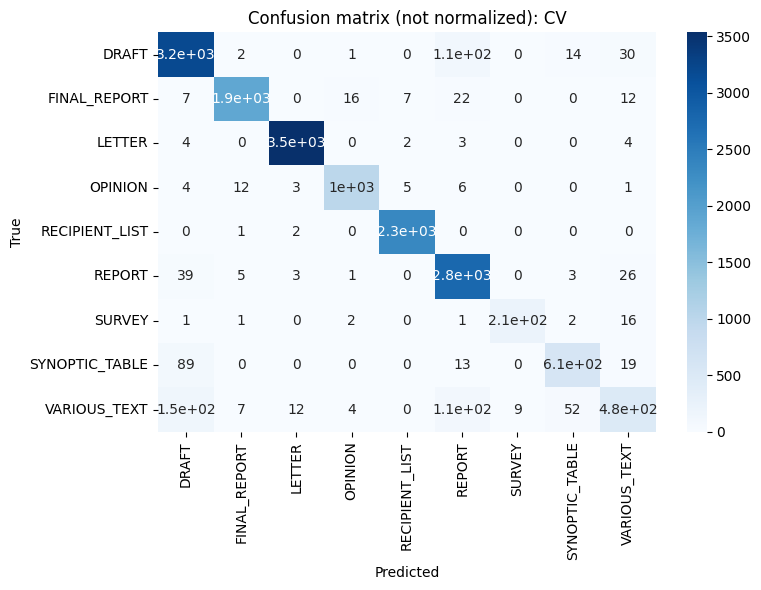

In [34]:
report = sklearn.metrics.classification_report(y_train, y_cv_predicted, zero_division=np.nan)
mlflow.log_text(report, "cv_classification_report.txt")
print(report)
cm = plotting.plot_confusion_matrix_heatmap(y_train, y_cv_predicted, title="CV")
mlflow.log_figure(cm, "cv_confusion_matrix.png")
display(cm)

## Training

In [35]:
classifier_test = demokratis_ml.models.document_types.model.create_classifier(
    embedding_dimension=embedding_dimension,
    params=HYPERPARAMETERS,
    random_state=RANDOM_STATE,
)
classifier_test.fit(X_train, y_train)

2025/10/07 14:45:55 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/10/07 14:47:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


,steps,"[('simpleimputer', ...), ('columntransformer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'constant'
,fill_value,-1.0
,copy,True
,add_indicator,False
,keep_empty_features,False
,transformers,"[('embeddings', ...), ('extra_features', ...), ...]"


## Evaluation on test_2

                precision    recall  f1-score   support

         DRAFT       0.88      0.89      0.88        79
  FINAL_REPORT       0.89      0.96      0.92        25
        LETTER       0.99      1.00      1.00       107
       OPINION       0.67      0.50      0.57         4
RECIPIENT_LIST       1.00      1.00      1.00        45
        REPORT       0.87      0.95      0.91       131
        SURVEY       1.00      0.92      0.96        13
SYNOPTIC_TABLE       0.95      0.97      0.96        65
  VARIOUS_TEXT       0.96      0.78      0.86        85

      accuracy                           0.93       554
     macro avg       0.91      0.89      0.90       554
  weighted avg       0.93      0.93      0.93       554



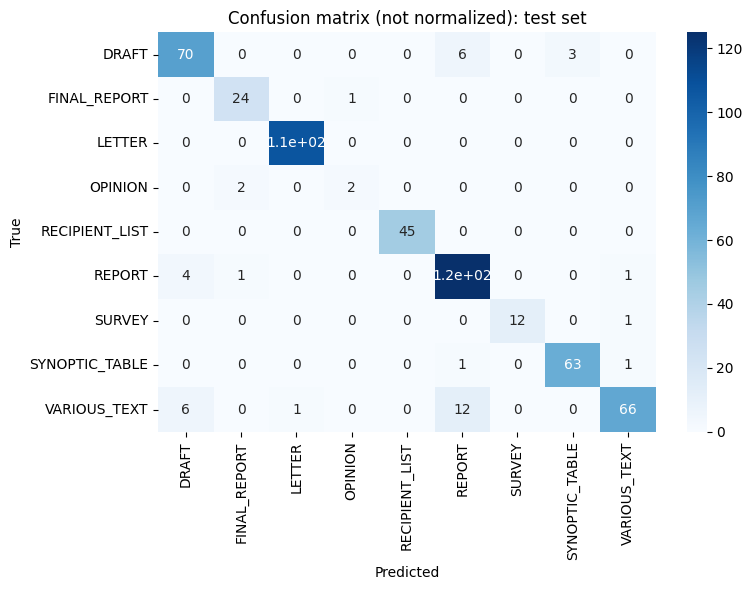

{'test_accuracy': 0.9278,
 'test_f1': 0.9267,
 'test_precision': 0.9298,
 'test_recall': 0.9278}


In [36]:
y_test_2_predicted = classifier_test.predict(X_test_2)

# Classification report
report = sklearn.metrics.classification_report(
    y_test_2,
    y_test_2_predicted,
    zero_division=np.nan,
)
mlflow.log_text(report, "test_classification_report.txt")
print(report)

# Confusion matrix
cm = plotting.plot_confusion_matrix_heatmap(y_test_2, y_test_2_predicted, title="test set")
mlflow.log_figure(cm, "test_confusion_matrix.png")
display(cm)

# Metrics
test_metrics = sklearn.metrics.precision_recall_fscore_support(
    y_test_2,
    y_test_2_predicted,
    average="weighted",
    zero_division=np.nan,
)
utils.log_metrics(
    test_precision=test_metrics[0],
    test_recall=test_metrics[1],
    test_f1=test_metrics[2],
    test_accuracy=sklearn.metrics.accuracy_score(y_test_2, y_test_2_predicted),
    # test_top_k_accuracy=sklearn.metrics.top_k_accuracy_score(y_test_2, classifier_test_2.predict_proba(X_test_2)),
)

### Feature importance

In [37]:
# forest = classifier_test.named_steps["randomforestclassifier"]
# pca = demokratis_ml.models.document_types.model.get_pca_step(classifier_test)
# assert pca is not None

# forest_importances = pd.Series(
#     forest.feature_importances_,
#     index=(
#         [f"embedding_{i:02d}" for i in range(pca.n_components)]
#         + list(demokratis_ml.models.document_types.model.EXTRA_FEATURE_COLUMNS)
#         + list(demokratis_ml.models.document_types.model.EXTRA_CATEGORICAL_COLUMNS)
#     ),
# )
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# fig, ax = plt.subplots(figsize=(12, 2.5 * np.log(len(forest_importances))))
# forest_importances.plot.barh(xerr=std, ax=ax)
# ax.invert_yaxis()  # start with embeddings at the top
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

# mlflow.log_figure(fig, "feature_importance_mdi.png")

### Results per canton

In [38]:
df_eval = df_input_test_2.copy()
df_eval["document_type_predicted"] = y_test_2_predicted

for canton_code, df_canton in df_eval.groupby("political_body", observed=False):
    # Skip the "ch" political_body, which is the federal level and not a canton
    if canton_code == "ch":
        continue
    print(f"\n{'-' * 60}\n{canton_code}\n{'-' * 60}")
    if df_canton.empty:
        print("No data")
    else:
        report = sklearn.metrics.classification_report(
            df_canton["document_type"], df_canton["document_type_predicted"], zero_division=np.nan
        )
        print(report)


------------------------------------------------------------
gr
------------------------------------------------------------
              precision    recall  f1-score   support

       DRAFT       1.00      1.00      1.00         5
      LETTER       1.00      1.00      1.00         4
      REPORT       0.50      1.00      0.67         1
VARIOUS_TEXT        nan      0.00      0.00         1

    accuracy                           0.91        11
   macro avg       0.83      0.75      0.67        11
weighted avg       0.95      0.91      0.88        11


------------------------------------------------------------
ow
------------------------------------------------------------
                precision    recall  f1-score   support

         DRAFT       0.75      1.00      0.86         3
  FINAL_REPORT       1.00      1.00      1.00         3
        LETTER       1.00      1.00      1.00         1
RECIPIENT_LIST       1.00      1.00      1.00         3
        REPORT       1.00      1

## Comparison to the rule-based model

In [39]:
# We must erase the true labels first because the rule-based model doesn't overwrite existing labels.
_df = df_input_test_2.copy()
_df.loc[:, "document_type"] = None
# Explicit class-merging step is needed because the rule-based model may output any class.
y_test_predicted_rules = demokratis_ml.models.document_types.preprocessing.merge_classes(
    document_title_rule_model.predict(_df),
    demokratis_ml.models.document_types.preprocessing.MERGE_CLASSES,
)

INFO document_title_rule_model: 0.00% of documents already have labels
INFO document_title_rule_model: Labelled 0.36% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 1.99% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 1.62% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
WARNING document

                precision    recall  f1-score   support

         DRAFT       0.64      0.95      0.76        58
  FINAL_REPORT       0.67      0.55      0.60        11
        LETTER       0.96      1.00      0.98       104
RECIPIENT_LIST       1.00      1.00      1.00        37
        REPORT       0.91      0.79      0.85       109
        SURVEY       1.00      0.91      0.95        11
SYNOPTIC_TABLE       1.00      0.88      0.94        58
  VARIOUS_TEXT       0.89      0.74      0.81        43

      accuracy                           0.88       431
     macro avg       0.88      0.85      0.86       431
  weighted avg       0.90      0.88      0.89       431



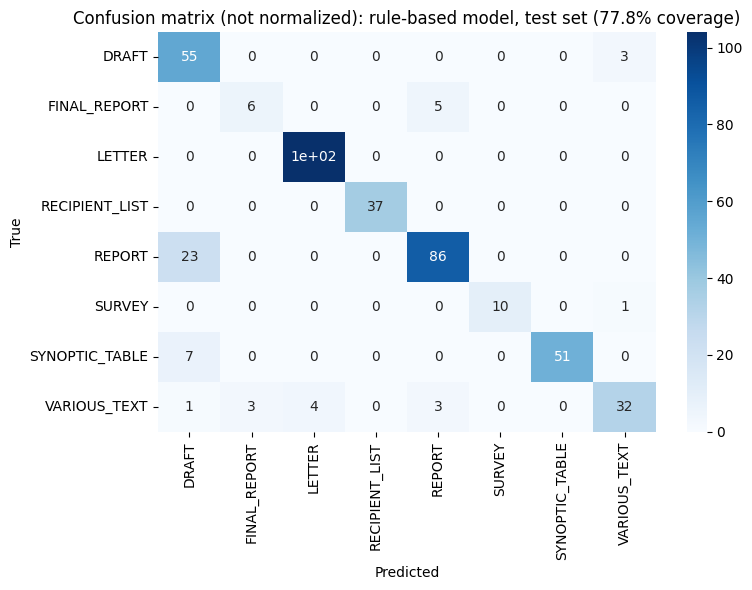

In [40]:
_y_true = y_test_2[y_test_predicted_rules.notna()]
_y_predicted = y_test_predicted_rules[y_test_predicted_rules.notna()]

coverage = np.mean(y_test_predicted_rules.notna())
print(sklearn.metrics.classification_report(_y_true, _y_predicted, zero_division=np.nan))
plotting.plot_confusion_matrix_heatmap(
    _y_true,
    _y_predicted,
    title=f"rule-based model, test set ({100 * coverage:.1f}% coverage)",
    # normalize="true",
)

## Display all test samples & predictions

In [41]:
# Uncomment to display a comparison of rule-based and ML-based predictions for every test document.

# df_display = df_input_test_2.copy()
# df_display["prediction_rule"] = y_test_predicted_rules
# df_display["prediction_ml"] = y_test_2_predicted

# df_display[
#     [
#         "document_uuid",
#         "political_body",
#         "consultation_url",
#         "document_source_url",
#         "document_title",
#         "document_type",
#         "prediction_rule",
#         "prediction_ml",
#     ]
# ].style.format(
#     {
#         "consultation_url": lambda x: f'<a href="{x}">vnl</a>',
#         "document_source_url": lambda x: f'<a href="{x}">doc</a>',
#     }
# ).apply(
#     lambda row: [
#         f"color: {'green' if row[col] == row['document_type'] else 'red'}"
#         if col in {"prediction_rule", "prediction_ml"}
#         else ""
#         for col in row.index
#     ],
#     axis=1,
# ).set_table_styles([{"selector": "th,td", "props": [("text-align", "left")]}])

***

# End run

In [42]:
# mlflow.sklearn.log_model(
#     classifier_test,
#     artifact_path="model",
#     registered_model_name="document_type_classifier",
# )

In [43]:
mlflow.end_run()

🏃 View run dapper-frog-74 at: https://mlflow.ml1.demokratis.ch/#/experiments/4/runs/6e20538b61ea48d1bb07bf88d2a12f23
🧪 View experiment at: https://mlflow.ml1.demokratis.ch/#/experiments/4


***

# Cleanlab

In [44]:
RUN_CLEANLAB = False

In [45]:
import cleanlab

from research.lib import cleanlab_analysis

if RUN_CLEANLAB:
    df_cleanlab = pd.concat([df_input_train, df_input_test_1, df_input_test_2], ignore_index=True)
    X_cleanlab, y_cleanlab = demokratis_ml.models.document_types.model.create_matrices(df_cleanlab)
    print(X_cleanlab.shape)
    classifier_cleanlab = demokratis_ml.models.document_types.model.create_classifier(
        embedding_dimension=embedding_dimension,
        params=HYPERPARAMETERS,
        random_state=RANDOM_STATE,
    )
    pred_probs = sklearn.model_selection.cross_val_predict(
        estimator=classifier_cleanlab,
        X=X_cleanlab,
        y=y_cleanlab,
        cv=CV_FOLDS,
        method="predict_proba",
        n_jobs=-1,
        verbose=2,
    )
    print(pred_probs.shape)
    assert pred_probs.shape[0] == len(df_cleanlab)

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO datasets: Duckdb version 1.3.2 available.


In [46]:
if RUN_CLEANLAB:
    lab = cleanlab.Datalab(data=df_cleanlab, label_name="document_type")
    lab.find_issues(pred_probs=pred_probs, features=X_cleanlab)
    lab.report()

In [47]:
if RUN_CLEANLAB:
    df_output = df_cleanlab.copy()
    df_output["year"] = df_output["consultation_start_date"].dt.year
    df_output["edit_link"] = df_output.apply(
        lambda d: f"https://www.demokratis.ch/de/consultation/{d['consultation_identifier']}/admin/document/{d['document_uuid']}/edit",
        axis=1,
    )
    df_output = df_output[
        [
            "edit_link",
            "consultation_identifier",
            "document_uuid",
            "political_body",
            "year",
            "consultation_url",
            "document_source_url",
            "document_title",
            "document_type",
            # Features:
            "count_pages",
            "count_pages_containing_tables",
            "average_page_aspect_ratio",
            "fraction_pages_containing_tables",
            "contains_synopse_keyword",
            "contains_salutation",
        ]
    ]

    cleanlab_analysis.cleanlab_issues_to_excel(
        lab,
        pred_probs=pred_probs,
        dataset=df_output,
        output_path=f"cleanlab_issues_{DATA_VERSION}.xlsx",
        linkify_columns={
            "edit_link",
            "consultation_url",
            # "document_source_url",  # Odd characters in some URLs cause Excel errors
        },
        issue_types=(
            "label",
            # "near_duplicate",
            # "outlier",
            # "underperforming_group",
            # "non_iid",
        ),
    )